### Visualizing the Distrubitions of Predictions from a Random Forest

#### Introduction

Random forests are an ensemble method. It constructs many decision trees and aggregates them via majority vote (classification) or by taking the mean (regression). Therefore in the end one prediction is given for each instance. This is great becasue most data scientists want / need a point estimate, but what if an interval estimate is desired? This is where knowing the distrubution of the of the individual predictions comes into play. Using Python and sklearn I will demonstrate how to pull out each instances predictions from a random forest.

#### Dataset

I am going to demonstrate this tactic using a dataset scraped from www.basketball-reference.com. See below for a link to GitHub repository that holds the data and code. Our goal is to obtain the predictions from a model that does the following: predict a player's minutes played during the 2018 NBA season given data from the 2017 NBA season. To be included in the dataset a player has to have played in both seasons.

Lets start by importing the necessary packages, loading the dataset and setting all the null values to 0 (setting the null values to 0 is not best practice but is done for simplicity):

In [104]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [105]:
# this is hardcoded to where I stored the file
nba_df = pd.read_csv('data/totals_1976_2018.csv')
nba_df.fillna(0, inplace=True)

We will create two seperate dataframes. One will hold the 2017 data and the other will hold the 2018 data. Only two columns will be kept in the 2018 dataframe since we are, a player identifier ('playerid') and the label / response ('mp' -- which will be renamed 'mp2018') that we are trying to predict.

In [106]:
nba2017 = nba_df.loc[nba_df['year'] == 2017].reset_index(drop=True)
nba2018 = nba_df.loc[nba_df['year'] == 2018, ['playerid', 'mp']].reset_index(drop=True)

nba2018.rename(columns={'mp': 'mp2018'}, inplace=True)

As previoulsy mentioned only observations that appear in both seasons should appear in our final dataframe. We accomplish this by using the 'isin' operator available in pandas.

In [107]:
final_df = nba2017[nba2017['playerid'].isin(nba2018['playerid'].tolist())]

To complete our final dataframe, 'final_df', we will merge the response from 'nba2018' into it.

In [108]:
final_df = pd.merge(final_df,
                    nba2018,
                    on=['playerid'],
                    how='left')

Lets look at the top 3 rows of 'final_df' and the the first 10 columns:

In [109]:
final_df.iloc[:3, :10]

,year,player,playerid,pos,age,tm,g,gs,mp,fg_totals
0,2017,Alex Abrines,abrinal01,SG,23,OKC,68,6.0,1055,134
1,2017,Quincy Acy,acyqu01,PF,26,TOT,38,1.0,558,70
2,2017,Steven Adams,adamsst01,C,23,OKC,80,80.0,2389,374


For simplicity and clarity lets create lists of the features that we are going to use along with features that we are not going to use. First will create a list manually that consists of static features. These are festures that more of less identify the player. We will then create a list that contains the response, in this case it is 'mp2018'. The final list created will be of the features that are going to be used to predict the response. This list will be created via list comprehension.

In [110]:
# static features
static_feats = ['year', 'player', 'playerid', 'pos', 'tm']

# response
response = 'mp2018'

# input features
input_features = [c for c in final_df if c not in static_feats + [response]]

Now that the data has been transformed into an analyzable format we can instantiate a random forest model that consists of 100 trees and fit it to the data:

In [111]:
NTREES = 100

reg_rf = RandomForestRegressor(n_estimators=NTREES,
                               oob_score=True,
                               random_state=23)
reg_rf.fit(X=final_df.loc[:, input_features],
           y=final_df[response])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=23,
           verbose=0, warm_start=False)

All of the information for the 100 built decision trees is held within the estimators\_ method. We can view the the parameters of the first tree by calling the following code:

In [112]:
reg_rf.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False,
           random_state=74293843, splitter='best')

As you can see this displays the parameters of the first decision tree. You also know that is the first decision tree because it begins with 'DecisionTreeRegressor'. The predictions that the first decision tree produces can be ascertained by tacking on the a predict method that calls the data located in 'final_df'. This returns a numpy array that is the same length as the row dimension of 'final_df':

In [113]:
len(reg_rf.estimators_[0].predict(X=final_df.loc[:, input_features])) == final_df.shape[0]

True

Lets look at the first five entries to confirm that we the result is numpy array:

In [114]:
reg_rf.estimators_[0].predict(X=final_df.loc[:, input_features])[:5]

array([ 1134.,  1353.,  2487.,  1651.,    49.])

With an understanding of how to acquire predictions from one tree, we can loop through each tree, calculate the predictions and then store them into a list. The number of iterations will be equal to the number of trees that are in our forest. In this case there are 100 individual trees.

In [115]:
data_list = []
for i in range(NTREES):
    tmp_array = reg_rf.estimators_[i].predict(X=final_df.loc[:, input_features])
    # store 'tmp_array' into a dataframe
    tmp_tbl = pd.DataFrame(tmp_array, columns=['tree_' + str(i+1)])
    # store the dataframe into a list
    data_list.append(tmp_tbl)

Next we turn our list of dataframes into one big dataframe that houses all of the predictions. This dataframe should have have the same umber of rows of 'final_df'. The number of columns should be equal to the number of trees, 100, in our forest.

In [116]:
pred_df = pd.concat(data_list, axis=1)

print(pred_df.shape[0] == final_df.shape[0])

True


Lets view the first three rows and the first five columns of 'pred_df':

In [117]:
pred_df.iloc[:3, :5]

,tree_1,tree_2,tree_3,tree_4,tree_5
0,1134.0,1134.0,1134.0,2282.0,1134.0
1,1353.0,1359.0,1359.0,1359.0,1359.0
2,2487.0,2487.0,1836.0,2463.0,2487.0


The one thing that 'pred_df' does not have is a player identifier. In order to add one will create a new datframe that holds the player's name and unique identifier from 'final_df' and then concatenate it to 'pred_df'.

In [118]:
id_df = final_df.loc[:, ['player', 'playerid']]
pred_df = pd.concat([id_df, pred_df], axis=1)

Once again we will view the first three rows and the first five columns to confirm that the dataframes have been concatenated correctly. The result should contain two columns that correspond to the player's name and unique identifier and three columns that correspond to the predictions from the first three trees.

In [119]:
pred_df.iloc[:3, :5]

,player,playerid,tree_1,tree_2,tree_3
0,Alex Abrines,abrinal01,1134.0,1134.0,1134.0
1,Quincy Acy,acyqu01,1353.0,1359.0,1359.0
2,Steven Adams,adamsst01,2487.0,2487.0,1836.0


Know that we have all the predictions into a nice table we can begin to visualize the distrubutions of individual players. This can be done by creating a dataframe that includes only the trees of a particular player and then pass it to a visualiztion package such as matplotlib or seaborn. Let's go through this step-by-step:

In [120]:
# Step 1: create datframe of particular player
player_name = 'LeBron James'
tree_cols = [t for t in pred_tbl if 'tree_' in t]
player_tbl = pred_tbl.loc[pred_tbl['player'] == player_name, tree_cols]

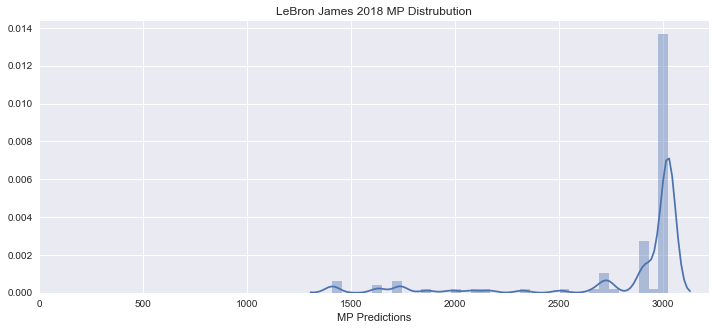

In [129]:
# Step 2: pass this dataframe into visualization package, here we are using
#  seaborn with a matplotlib backend
plt.figure(figsize=(12, 5))
sns.distplot(player_tbl)
plt.title('{} 2018 MP Distrubution'.format(player_name))
plt.xlabel('MP Predictions')
plt.xlim(0)
plt.savefig('distLJ.png')

Lets say that you do not know all of the player's names in the dataframe and simply want to visualize a random instance. This can be done by passing in an integer that corresponds to an associated row number. The caveat being that the integer passed has to reside in the row range of the respective dataframe. An example of this is implemented in the following code: 

(0, 2168.8689216030607)

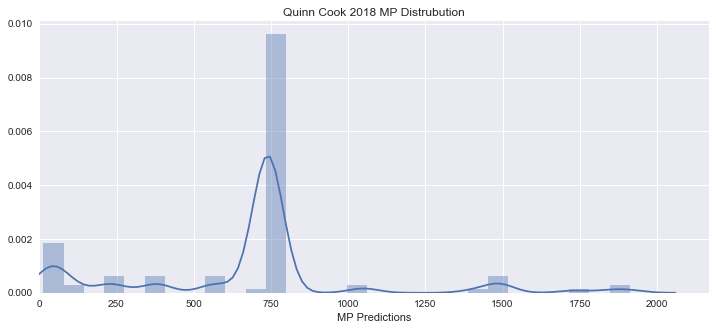

In [128]:
# assign a random number to a variable object
random_int = np.random.randint(0, pred_tbl.shape[0])

# get only the columns from 'pred_tbl' that are needed
tree_cols = [t for t in pred_tbl if 'tree_' in t]

# create dataframe
player_int_tbl = pred_tbl.loc[random_int, tree_cols]

# get players name
player_int_name = pred_tbl.loc[random_int, 'player']

# graph distrubution
plt.figure(figsize=(12, 5))
sns.distplot(player_int_tbl)
plt.title('{} 2018 MP Distrubution'.format(player_int_name))
plt.xlabel('MP Predictions')
plt.xlim(0)
plt.savefig('randomDist.png')

There you have it; a way to visualize the distrubution of the predictions of a random forest. From here you can determine summary statistics for each player's predictions to better understand the distrubution. I hope that this article was informative and opened a new way to look at the inner workings of a random forest. If you liked it please show your appreciation with claps.

#### Link to data and code

https://github.com/jharmitage23/Distrubution-of-Random-Forest-Predictions